In [102]:
%pip install matplotlib
%pip install numpy
%pip install seaborn



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [104]:
#load the dataset
dataset = 'datasets/housing/housing.csv'
df = pd.read_csv(dataset)
df.head()
df['id'] = np.random.randint(0, 1000000, size=len(df))


In [105]:

# housing_data_with_id = df.reset_index()
# # let's generate id with random numbers
# housing_data_with_id['id'] = np.random.randint(0, 1000000, size=len(housing_data_with_id))
# housing_data_with_id.head()
df.describe()


# Train and test split using deterministic hashing
# This approach ensures that the same instances end up in the test set across multiple runs,
# which is important for reproducibility and comparing model iterations

from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    """
    Determines if an instance should be in the test set based on its identifier.
    
    Args:
        identifier: Unique identifier for the instance
        test_ratio: Desired proportion of data to use for testing (between 0 and 1)
    
    Returns:
        Boolean indicating if instance should be in test set
    """
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(df, test_ratio, id_column):
    """
    Splits data into training and test sets using hashing of IDs.
    
    Args:
        df: Pandas DataFrame containing the dataset
        test_ratio: Proportion of data to use for testing (between 0 and 1) 
        id_column: Name of column containing unique identifiers
    
    Returns:
        train_set, test_set: The split DataFrame portions
    """
    print(type(df['id']))
    ids = df['id']
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return df.loc[~in_test_set], df.loc[in_test_set]

# Split data into 80% training and 20% test sets
train_data, test_data = split_data_with_id_hash(df, 0.2, "id")


# Display first few rows of both sets
train_data.head()
test_data.head()


<class 'pandas.core.series.Series'>


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
17,-122.27,37.85,52.0,1228.0,293.0,648.0,303.0,2.1202,155500.0,NEAR BAY,445970
18,-122.26,37.84,50.0,2239.0,455.0,990.0,419.0,1.9911,158700.0,NEAR BAY,961783
21,-122.27,37.85,42.0,1639.0,367.0,929.0,366.0,1.7135,159800.0,NEAR BAY,853162
22,-122.27,37.84,52.0,2436.0,541.0,1015.0,478.0,1.7250,113900.0,NEAR BAY,804247
23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY,797240


not same length
206497.33381782947


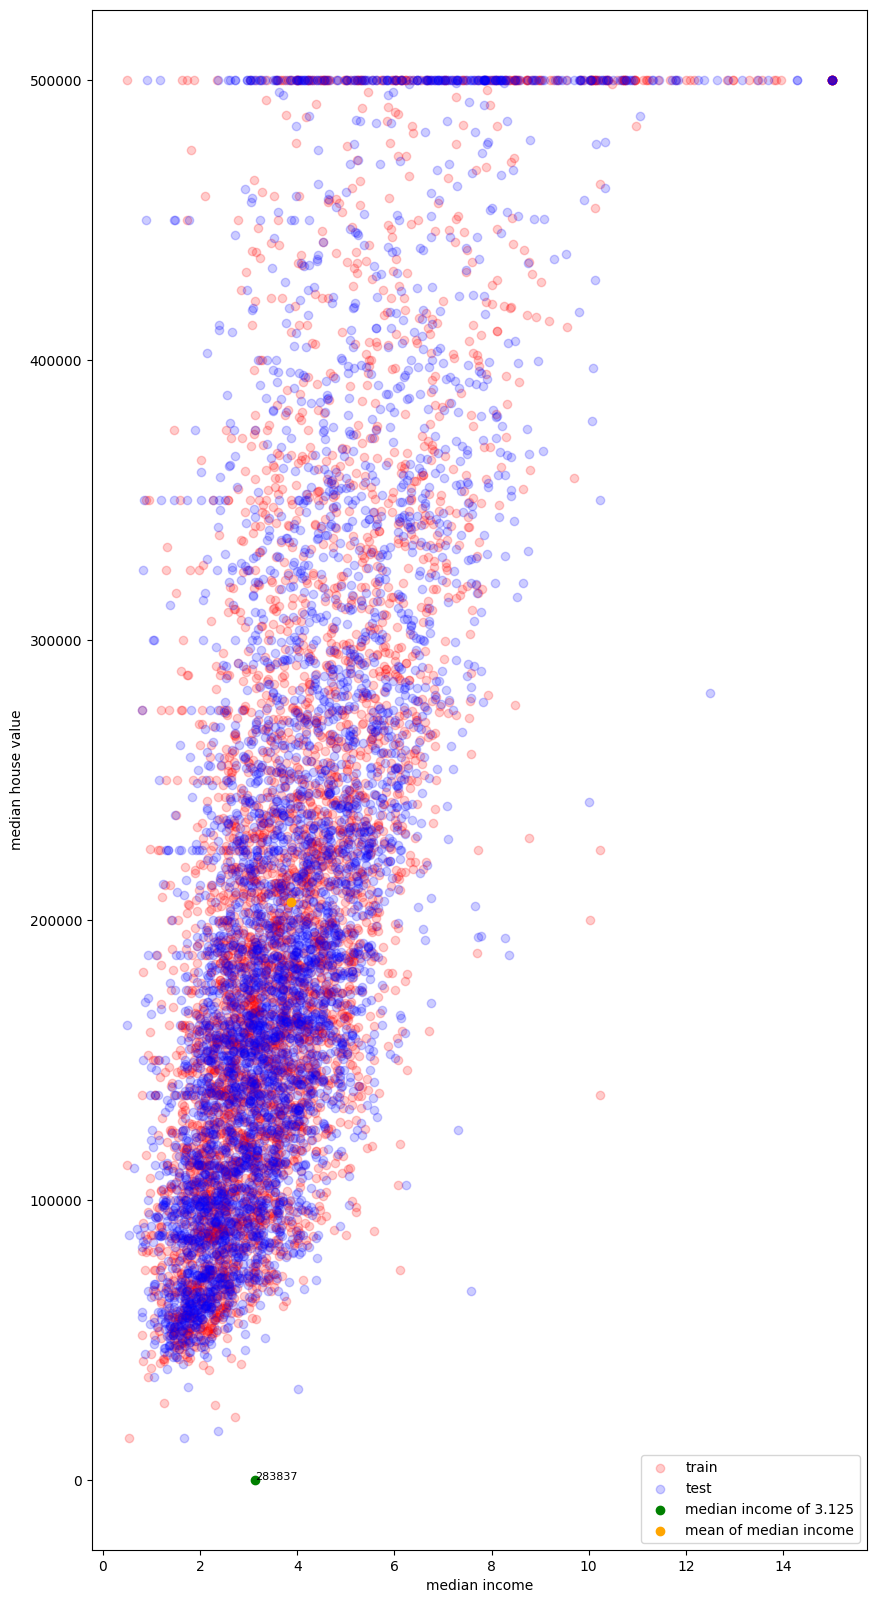

In [120]:
# 📊 Data Preparation and Visualization
# Now that we have the train and test data, we can start plotting
# First with train data using sklearn

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# 📏 Compare Dataset Sizes
# Let's compare the median income of train and test sets
train_set.shape[0] == test_set.shape[0]
if len(train_set)== len(test_set):
    print("same length")
else:
    print("not same length")

# ✂️ Data Length Adjustment
# If lengths are not same, make them equal
min_length = min(len(train_set), len(test_set))

# Truncate datasets to minimum length
train_set = train_set.iloc[:min_length]
test_set = test_set.iloc[:min_length]

# 📈 Data Visualization
# Now that both sets have same length, create scatter plot
plt.figure(figsize=(10, 20))
plt.xlabel('median income')
plt.ylabel('median house value')

# 🎨 Plot Data Points
plt.scatter(train_set['median_income'], train_set['median_house_value'], alpha=0.2, color='red')
plt.scatter(test_set['median_income'], test_set['median_house_value'], alpha=0.2, color='blue')

print(train_set['median_house_value'].mean())

# let's add the id of median from train set
plt.text(3.125, 24.0, train_set[train_set['median_income'] == 3.125]['id'].values[0], fontsize=8)

# 🎯 Highlight Reference Point
plt.scatter(3.125, 24.0, alpha=1, color='green')


#lets add mean of median income
plt.scatter(train_set['median_income'].mean(), train_set['median_house_value'].mean(), alpha=1, color='orange')
plt.legend(['train', 'test', 'median income of 3.125', 'mean of median income'])
plt.show()







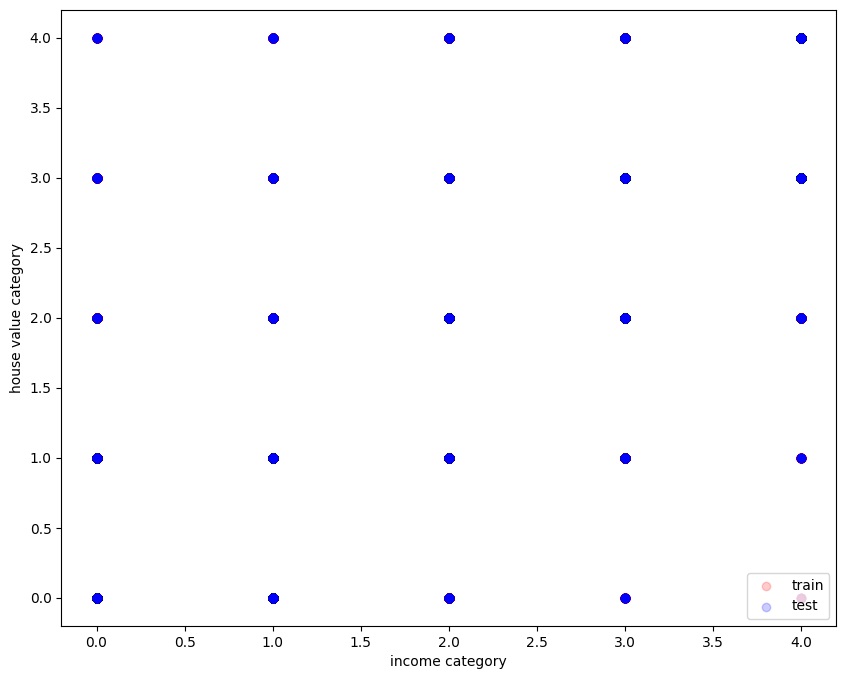

In [90]:
# 🎯 Stratified Sampling Implementation
# This technique ensures that the proportions of samples in each category are preserved
from sklearn.model_selection import StratifiedShuffleSplit
train_set_income_strat_splits = []
test_set_income_strat_splits = []
train_set_house_value_strat_splits = []
test_set_house_value_strat_splits = []

# 📊 Create Categories
# Divide data into 5 equal-sized categories (quintiles) for both income and house value
df['income_cat'] = pd.qcut(df['median_income'], 5, labels=False)  # 0-4 categories
df['house_value_cat'] = pd.qcut(df['median_house_value'], 5, labels=False)  # 0-4 categories

# 🔄 Split Data Based on Income Categories
# Create stratified splits maintaining income category proportions
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    train_set_income_strat_splits.append(strat_train_set)
    test_set_income_strat_splits.append(strat_test_set)

# 🏠 Split Data Based on House Value Categories
# Create stratified splits maintaining house value category proportions
for train_set, test_set in split.split(df, df['house_value_cat']):
    strat_train_set = df.loc[train_set]
    strat_test_set = df.loc[test_set]
    train_set_house_value_strat_splits.append(strat_train_set)
    test_set_house_value_strat_splits.append(strat_test_set)

# 🔄 Reset Indices
# Extract first split and reset indices for clean data handling
train_set_income_strat_splits = train_set_income_strat_splits[0].reset_index(drop=True)
test_set_income_strat_splits = test_set_income_strat_splits[0].reset_index(drop=True)
train_set_house_value_strat_splits = train_set_house_value_strat_splits[0].reset_index(drop=True)
test_set_house_value_strat_splits = test_set_house_value_strat_splits[0].reset_index(drop=True)

# 📈 Visualization Setup
# Create scatter plot to visualize relationship between categories
plt.figure(figsize=(10, 8))
plt.xlabel('income category')
plt.ylabel('house value category')

# 🎨 Plot Data Points
# Red points for training set, blue points for test set
plt.scatter(train_set_income_strat_splits['income_cat'], train_set_income_strat_splits['house_value_cat'], alpha=0.2, color='red')
plt.scatter(test_set_income_strat_splits['income_cat'], test_set_income_strat_splits['house_value_cat'], alpha=0.2, color='blue')
plt.legend(['train', 'test'])
plt.show()




income_cat
2    0.210756
4    0.201308
0    0.199370
3    0.195979
1    0.192587
Name: count, dtype: float64


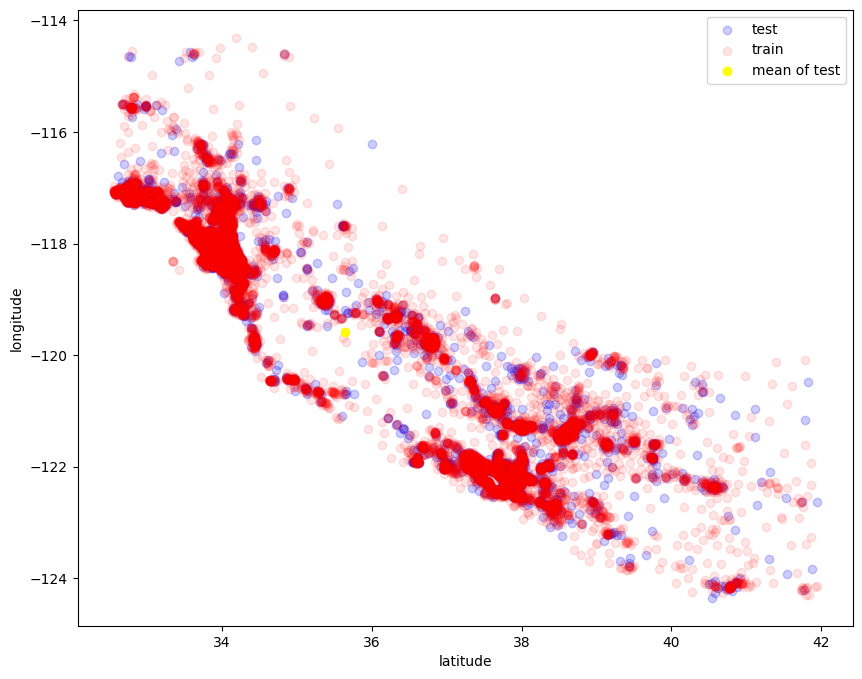

In [91]:
# lets do one quick calculation
calculated_test_set_income_cat_proportions = strat_test_set['income_cat'].value_counts() / len(strat_test_set)
print(calculated_test_set_income_cat_proportions)
# lets add more fun to graphs

plt.figure(figsize=(10, 8))
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.scatter(strat_test_set['latitude'], strat_test_set['longitude'], alpha=0.2, color='blue')
plt.scatter(strat_train_set['latitude'], strat_train_set['longitude'], alpha=0.1, color='red')
plt.legend(['test', 'train'])
#lets find mean of latitude and longitude and map it
mean_latitude = strat_test_set['latitude'].mean()
mean_longitude = strat_test_set['longitude'].mean()
plt.scatter(mean_latitude, mean_longitude, alpha=1, color='yellow')

plt.legend(['test', 'train', 'mean of test'])
plt.show()







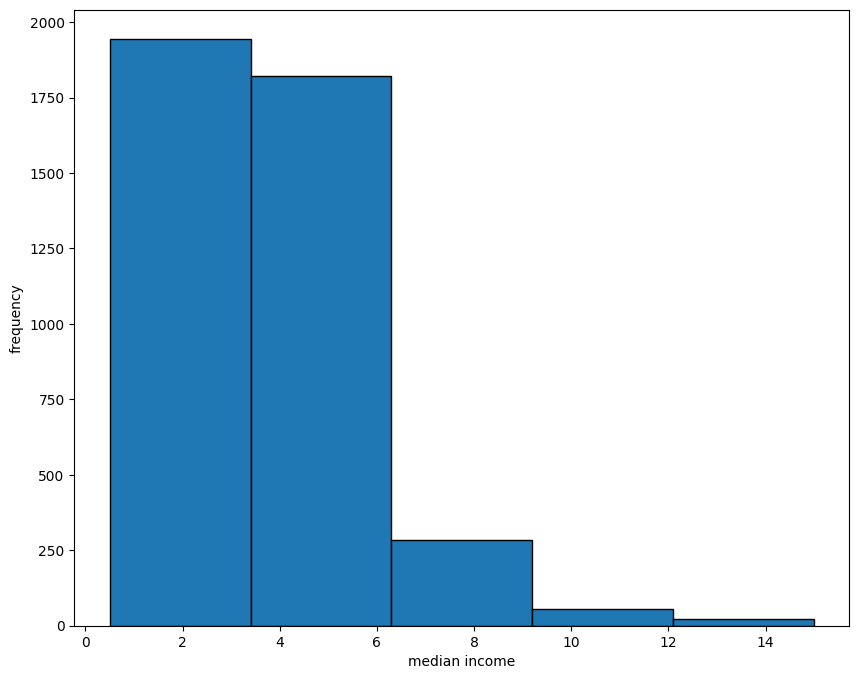

In [121]:
# generate histogram of median income
plt.figure(figsize=(10, 8))
plt.xlabel('median income')
plt.ylabel('frequency')
plt.hist(train_set['median_income'], bins=5, edgecolor='black')
plt.show()


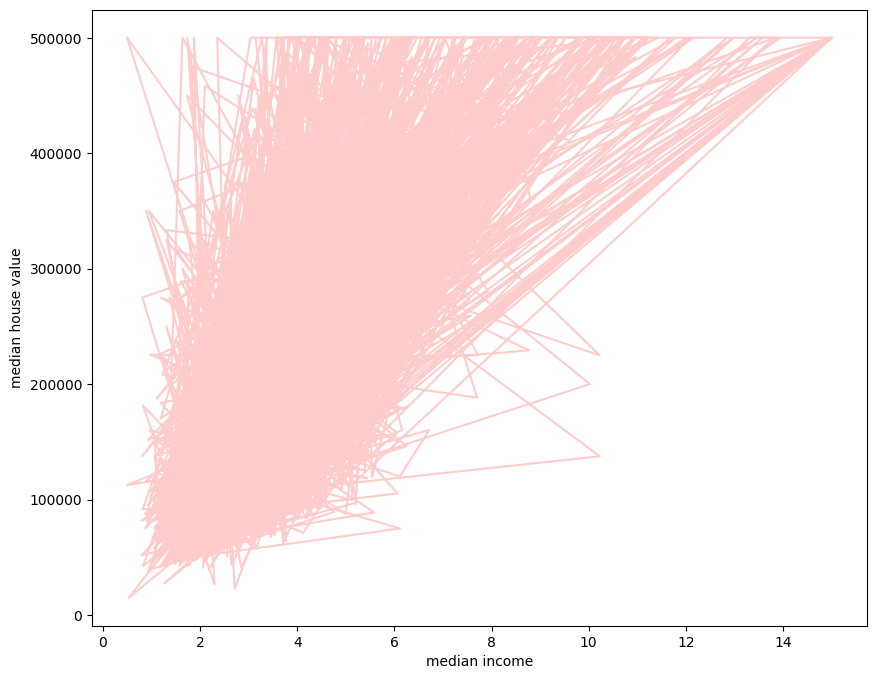

In [124]:
#generate line plot of median income
plt.figure(figsize=(10, 8))
plt.xlabel('median income')
plt.ylabel('median house value')
# change color of line for median income and median house value
plt.plot(train_set['median_income'], train_set['median_house_value'], alpha=0.2, color='red')
plt.plot(test_set['median_income'], test_set['median_house_value'], alpha=0.2, color='blue')
plt.show()
